In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
#import bambi as bmb
import xarray as xr
import random
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_context('paper')
sns.set_style('ticks')
plt.rc("axes.spines", top=False, right=False)
with matplotlib.style.context('arviz-doc'):
    az_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
sns.set_palette(az_colors)

def origo(ax=None):
    if ax is None:
        ax = plt.gca()
    x, y = ax.get_xlim(), ax.get_ylim()
    minx, maxx = min(x), max(x)
    miny, maxy = min(y), max(y)
    plt.ylim(min(0, miny), max(0, maxy))
    plt.xlim(min(0, minx), max(0, maxx))

class columns:
    def __rlshift__(self, df):
        "Left align columns of data frame: df << left()"
        left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
        left_aligned_df = left_aligned_df.set_table_styles(
        [dict(selector = 'th', props=[('text-align', 'left')])])
        display(left_aligned_df)
        

In [2]:
# scale = 0.35
# d = dict([(k, v*scale) for (k, v) in sns.plotting_context().items() if v is not None])
# d['figure.figsize'] = [1.8, 1.3]
# matplotlib.rcParams.update(d)
# make context for with statement:
# #matplotlib.style.context(d)

In [3]:
# plt.plot(np.random.random(10), np.random.random(10)-10)
# origo()

In [4]:
#Disable annoying "UserWarning: The figure layout has changed to tight" message
import warnings
warnings.filterwarnings('ignore', category=UserWarning
                        # , module='seaborn'
                       )
warnings.filterwarnings('ignore', category=FutureWarning,
                        # module='matplotlib'
                       )

# Read in data

Filter based on callability and remove X chromosome and adjust for missing coverage by extrapolating

In [5]:
data = pd.read_csv('../Reduced_Ne_Pi_recomb.csv')
#data.full_species.unique()

In [6]:
data = data[data['freq_mean']>0.7]
data = data[data['chr']!='chrX']
data['corrected_pi'] = data['PI']*data['freq_mean']

In [7]:
selected_groups = ['Gorilla_gorilla', 'Chiropotes_albinasus', 'Saimiri_ustus']
#selected_groups = data.full_species.unique()[:50]

In [8]:
# # subset data for testing
# data = data.loc[(data['chr'] == 'chr1') & (data.full_species.isin(selected_groups))]
# data = data.loc[(data['chr'] == 'chr1')]
# data = data.loc[(data.full_species.isin(selected_groups))]
data.reset_index(drop=True, inplace=True)
data.head()

,Unnamed: 0,genus,species,full_species,MEAN,MEDIAN,NE_MEAN,NE_MEDIAN,freq_mean,cm_per_mb,chr,PI,corrected_pi
0,2,Allenopithecus,nigroviridis,Allenopithecus_nigroviridis,8.357479e-09,8.297569e-09,52454.392022,48795.239046,0.809708,0.032423,chr1,0.001810,0.001466
1,3,Allenopithecus,nigroviridis,Allenopithecus_nigroviridis,8.357479e-09,8.297569e-09,52454.392022,48795.239046,0.716477,1.734505,chr1,0.002047,0.001466
2,4,Allenopithecus,nigroviridis,Allenopithecus_nigroviridis,8.357479e-09,8.297569e-09,52454.392022,48795.239046,0.784308,1.056430,chr1,0.002565,0.002012
3,5,Allenopithecus,nigroviridis,Allenopithecus_nigroviridis,8.357479e-09,8.297569e-09,52454.392022,48795.239046,0.747552,0.420616,chr1,0.001845,0.001379
4,6,Allenopithecus,nigroviridis,Allenopithecus_nigroviridis,8.357479e-09,8.297569e-09,52454.392022,48795.239046,0.783023,1.470184,chr1,0.001713,0.001342


In [9]:
data.full_species.unique()

array(['Allenopithecus_nigroviridis', 'Allochrocebus_lhoesti',
       'Allochrocebus_preussi', 'Allochrocebus_solatus',
       'Alouatta_belzebul', 'Alouatta_caraya', 'Alouatta_discolor',
       'Alouatta_juara', 'Alouatta_macconnelli', 'Alouatta_nigerrima',
       'Alouatta_palliata', 'Alouatta_puruensis', 'Alouatta_seniculus',
       'Aotus_azarae', 'Aotus_griseimembra', 'Aotus_trivirgatus',
       'Aotus_vociferans', 'Arctocebus_calabarensis', 'Ateles_belzebuth',
       'Ateles_chamek', 'Ateles_geoffroyi', 'Ateles_marginatus',
       'Ateles_paniscus', 'Cacajao_ayresi', 'Cacajao_calvus',
       'Cacajao_hosomi', 'Cacajao_melanocephalus', 'Callimico_goeldii',
       'Callithrix_geoffroyi', 'Callithrix_jacchus', 'Callithrix_kuhlii',
       'Cebuella_niveiventris', 'Cebuella_pygmaea', 'Cebus_albifrons',
       'Cebus_olivaceus', 'Cebus_unicolor', 'Cercocebus_chrysogaster',
       'Cercocebus_lunulatus', 'Cercocebus_torquatus',
       'Cercopithecus_ascanius', 'Cercopithecus_cephus',
  

In [10]:
np.log10(data['NE_MEDIAN'].mean()), np.log10(data['NE_MEDIAN']).mean()

(4.845759193883429, 4.749171266594735)

# Transform data

In [11]:
species_encoder = LabelEncoder()

gr = data.groupby('full_species')

df = pd.DataFrame(dict(
    
    # log scale and z transform Ne globally
    Ne = data.NE_MEDIAN.transform(np.log1p).transform(lambda sr: (sr - sr.mean()) / sr.std()),

    # log scale and z transform recombination rate by species
    rec_rate = gr.cm_per_mb.transform(np.log1p).transform(lambda sr: (sr - sr.mean()) / sr.std()),

    # z transform pi by species
    pi = gr.corrected_pi.transform(lambda sr: (sr - sr.mean()) / sr.std()),

    # species name for each observation
    full_species = data.full_species,

    # species to integer transform
    species = species_encoder.fit_transform(data.full_species)
    
))

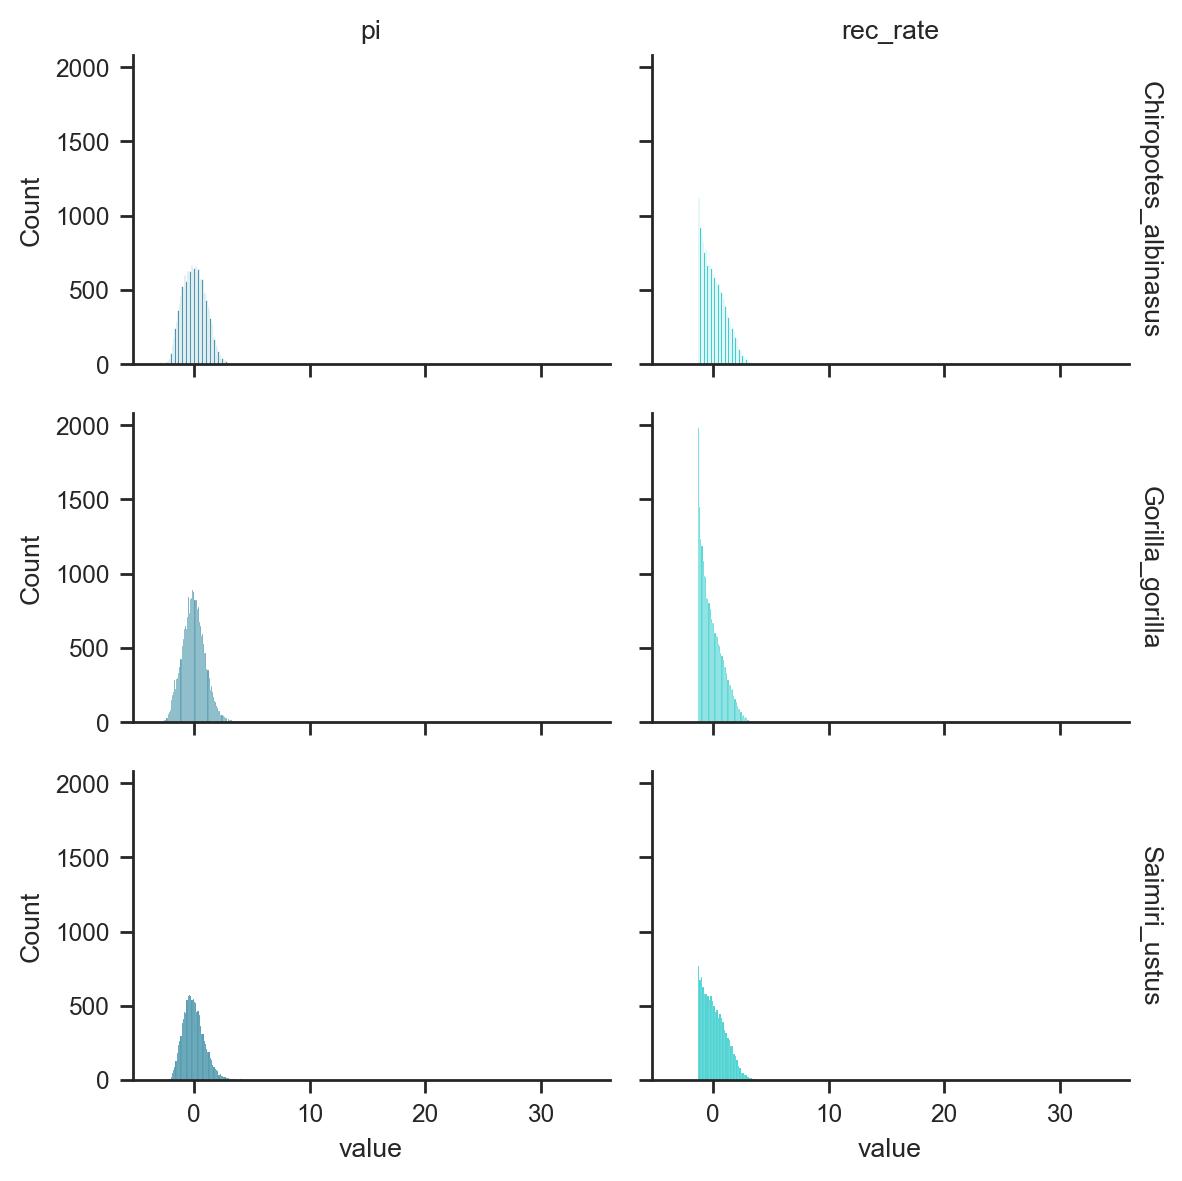

In [12]:
plot_df = df.loc[df.full_species.isin(selected_groups)].melt(id_vars='full_species', value_vars=['pi', 'rec_rate'])
g = sns.FacetGrid(plot_df, col="variable", row="full_species", hue="variable", margin_titles=True, height=2, aspect=1.5)
g.map_dataframe(sns.histplot, x="value")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
for ax in g.axes.flat:
    title = ax.get_title()
    ax.set_title(title, rotation=0)
plt.tight_layout()

In [13]:
# population_idx = 
# background_pi = 
# admixture_prop = 

# population_label = 
# dist_from_hybzone = 

# Observations

In [14]:
window_y_values = df.pi.values
window_x_values = df.rec_rate.values
global_group_names = pd.unique(species_encoder.inverse_transform(df.species))
global_group_indices = df.species
global_group_values = df[['full_species', 'Ne']].drop_duplicates().Ne.values

assert len(global_group_names) == len(global_group_values)
assert len(window_y_values) == len(window_x_values)
assert len(window_x_values) == len(global_group_indices)

# Hierarchical model

In [15]:
model_hierarchical = pm.Model(coords = {"global_group": global_group_names,
                           "obs_id": np.arange(len(window_x_values))})
non_centered = True

with model_hierarchical:
    # data
    window_dependent = pm.ConstantData('window_dependent', window_x_values, dims='obs_id')
    window_independent = pm.ConstantData('window_independent', window_y_values, dims='obs_id')
    global_group_member = pm.ConstantData('global_group_member', global_group_indices, dims='obs_id')
    global_dependent =  pm.ConstantData('global_dependent', global_group_values, dims='global_group')

    # hyperprior on window_independent ~ window_dependent intercept prior
    hyp_inter_inter = pm.Normal("hyp_inter_inter", mu=0, sigma=1)
    hyp_inter_slope = pm.Normal("hyp_inter_slope", mu=0, sigma=1)
    
    # hyperprior on window_independent ~ window_dependent slope prior
    hyp_slope_inter = pm.Normal("hyp_slope_inter", mu=0, sigma=1)
    hyp_slope_slope = pm.Normal("hyp_slope_slope", mu=0, sigma=1)

    # prior on residual variation on global_group intercepts
    group_inter_residual = pm.Normal("group_inter_residual", 0, sigma=1, dims="global_group")
    
    # prior on residual variation on global_group slopes
    group_slope_residual = pm.Normal("group_slope_residual", 0, sigma=1, dims="global_group")

    # prior on window_independent ~ window_dependent intercept for each global_group
    mu_inter = hyp_inter_inter + hyp_inter_slope * global_dependent
    sigma_inter = pm.Exponential("sigma_inter", 1)
    group_inter = pm.Deterministic("group_inter", mu_inter + group_inter_residual * sigma_inter, dims="global_group")

    # prior on window_independent ~ window_dependent slope for each global_group
    mu_slope = hyp_slope_inter + hyp_slope_slope * global_dependent
    sigma_slope = pm.Exponential("sigma_slope", 1)
    group_slope = pm.Deterministic("group_slope", mu_slope + group_slope_residual * sigma_slope, dims="global_group")
        
    # prior window_independent ~ window_dependent slope for each global_group
    mu_window_independent = group_inter[global_group_member] + group_slope[global_group_member] * window_dependent
    sigma_window_independent = pm.Exponential("sigma_window_independent", 0.01)

    # prior
    WindowIndependent = pm.Normal("Independent", mu=mu_window_independent, sigma=sigma_window_independent, observed=window_independent, dims="obs_id")

In [16]:
%%capture
fig, ax = plt.subplots()
g = pm.model_to_graphviz(model_hierarchical)
g.graph_attr.update(size="10,10")

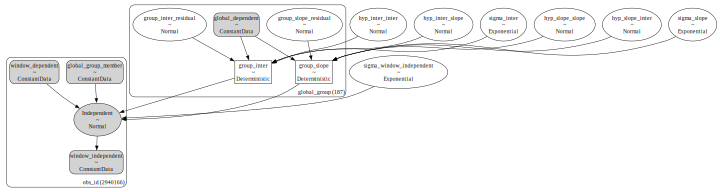

In [17]:
g

## Prior predictive checks

In [18]:
with model_hierarchical:
    idata_hierarchical = pm.sample_prior_predictive()

Sampling: [Independent, group_inter_residual, group_slope_residual, hyp_inter_inter, hyp_inter_slope, hyp_slope_inter, hyp_slope_slope, sigma_inter, sigma_slope, sigma_window_independent]


In [19]:
idata_hierarchical

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [20]:
prior = idata_hierarchical.prior.squeeze(drop=True)
prior

<xarray.Dataset>
Dimensions:                   (draw: 500, global_group: 187)
Coordinates:
  * draw                      (draw) int64 0 1 2 3 4 5 ... 495 496 497 498 499
  * global_group              (global_group) <U28 'Allenopithecus_nigroviridi...
Data variables:
    hyp_inter_inter           (draw) float64 0.112 1.488 ... 0.9384 -1.881
    hyp_inter_slope           (draw) float64 -0.5561 -0.4292 ... 0.5824 0.419
    hyp_slope_slope           (draw) float64 -1.911 3.159 ... 0.4494 0.4204
    hyp_slope_inter           (draw) float64 0.1881 0.8591 ... 0.6236 1.98
    group_slope_residual      (draw, global_group) float64 -1.212 ... -1.345
    sigma_slope               (draw) float64 0.1425 0.8475 ... 0.1908 0.01774
    group_inter               (draw, global_group) float64 -2.135 ... -0.886
    sigma_inter               (draw) float64 1.827 2.25 0.7161 ... 0.5169 0.7259
    group_slope               (draw, global_group) float64 0.4367 ... 2.055
    group_inter_residual      (draw, global_group) float64 -1.297 ... 1.234
    sigma_window_independent  (draw) float64 10.04 132.2 36.95 ... 140.6 111.6
Attributes:
    created_at:                 2024-02-29T20:53:10.178843
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.10.0

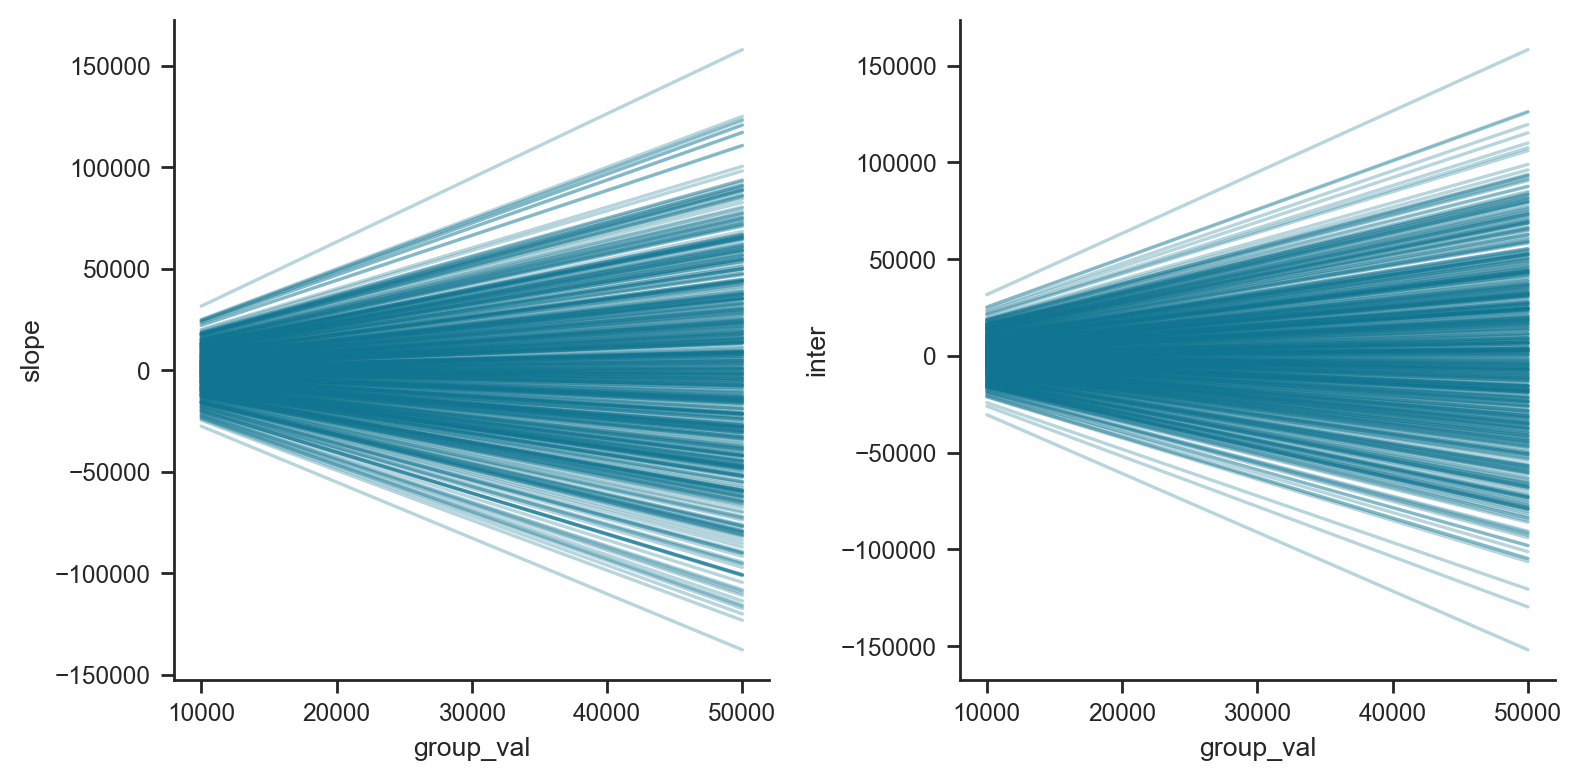

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

group_val = xr.DataArray(np.linspace(10000, 50000, 200), dims=["plot_dim"])
prior = idata_hierarchical.prior

slope = prior["hyp_slope_inter"] + prior["hyp_slope_slope"] * group_val
ax1.plot(group_val, slope.stack(sample=("chain", "draw")), c="C0", alpha=0.3)
ax1.set_xlabel("group_val")
ax1.set_ylabel("slope") 
inter = prior["hyp_inter_inter"] + prior["hyp_slope_inter"] * group_val
ax2.plot(group_val, inter.stack(sample=("chain", "draw")), c="C0", alpha=0.3)
ax2.set_xlabel("group_val")
ax2.set_ylabel("inter")
plt.tight_layout()

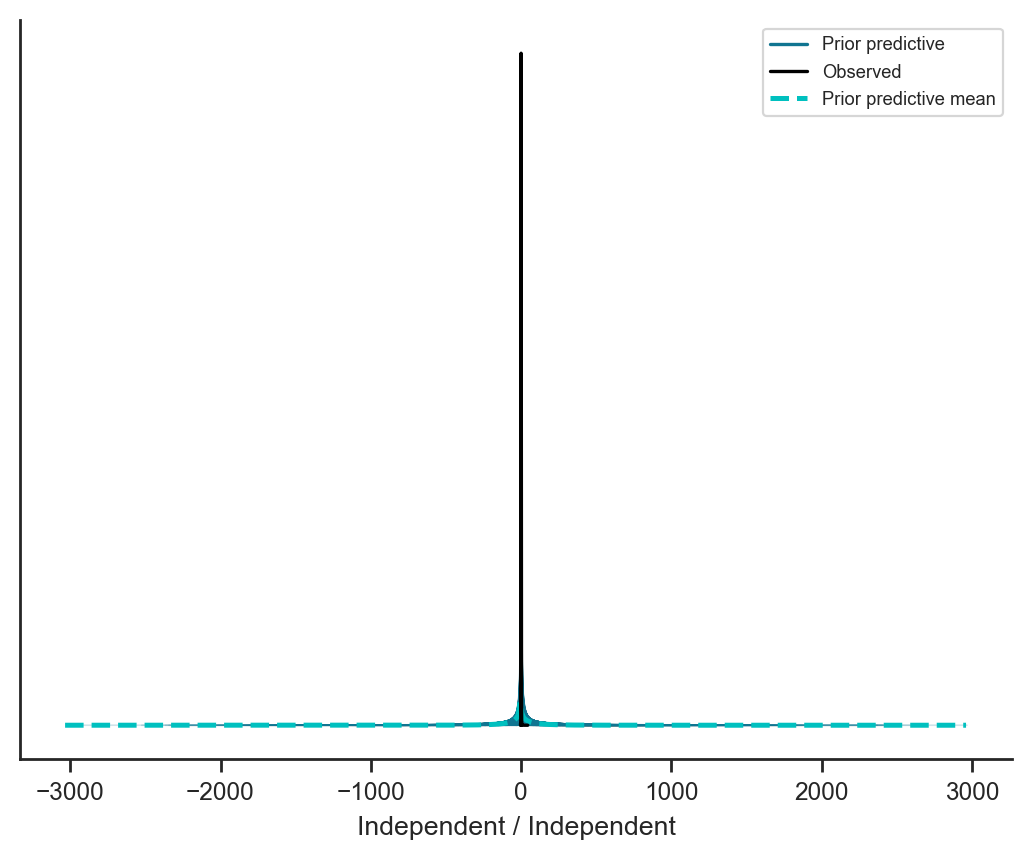

In [22]:
az.plot_ppc(idata_hierarchical, group='prior') ;

In [23]:
idata_hierarchical

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

## Model trace

In [ ]:
use_cached = False

trace_file = 'logne_model_hierarchical.nc'
if use_cached and os.path.exists(trace_file):
    with model_hierarchical:
         idata_hierarchical = az.from_netcdf(trace_file)
else:
    with model_hierarchical:
        idata_hierarchical = pm.sample(#1000, 
                          target_accept=0.95, 
                          return_inferencedata=True,
                          progressbar=True, 
            # cores=4, chains=4
        )
        idata_hierarchical.to_netcdf(trace_file)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [hyp_inter_inter, hyp_inter_slope, hyp_slope_inter, hyp_slope_slope, group_inter_residual, group_slope_residual, sigma_inter, sigma_slope, sigma_window_independent]


## Trace diagnostics

In [ ]:
az.plot_energy(idata_hierarchical);

In [ ]:
az.plot_trace(idata_hierarchical,
    # var_names=[],
    compact=True,
    figsize=(10, 20),
    chain_prop={"ls": "-"},
             )
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(12,  4))
axs[0].plot(idata_hierarchical.posterior.sel(chain=0)["sigma_slope"])
axs[0].set(ylabel="sigma_slope")
axs[1].plot(idata_hierarchical.posterior.sel(chain=0)["group_slope"])
axs[1].set(ylabel="group_slope");

In [ ]:
ax = az.plot_pair(
    idata_hierarchical,
    var_names=["group_slope", "sigma_slope"],
    coords=dict(global_group=selected_groups[0]),
    marginals=True,
    #marginal_kwargs={"kind": "hist"},
)
#ax[1, 0].set_title(selected_groups[1])

## Posterior predictive checks

In [ ]:
with model_hierarchical:
    idata_hierarchical.extend(pm.sample_posterior_predictive(idata_hierarchical))

# # thin a sampled inferencedata by keeping 1 out of every 5 draws before passing it to sample_posterior_predictive
# thinned_idat = idat.sel(draw=slice(None, None, 5))
# with model_hierarchical:
#     idata_hierarchical.extend(pm.sample_posterior_predictive(thinned_idata_hierarchical))

# # generate 5 posterior predictive samples per posterior sample
# expanded_data = idata_hierarchical.posterior.expand_dims(pred_id=5)
# with model_hierarchical:
#     idata_hierarchical.extend(pm.sample_posterior_predictive(expanded_data))

In [ ]:
idata_hierarchical

In [ ]:
az.summary(idata_hierarchical, round_to=2)

In [ ]:
post_mean = idata_hierarchical.posterior.mean(dim=("chain", "draw"))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

group_val = xr.DataArray(np.linspace(10000, 50000, 200), dims=["plot_dim"])
posterior = idata_hierarchical.posterior

slope = posterior["hyp_slope_inter"] + posterior["hyp_slope_slope"] * group_val
ax1.plot(group_val, slope.stack(sample=("chain", "draw")), c="C0", alpha=0.01)
ax1.plot(group_val, post_mean["hyp_slope_inter"] + post_mean["hyp_slope_slope"] * group_val, c="C2")
ax1.set_xlabel("group_val")
ax1.set_ylabel("slope") 
inter = posterior["hyp_inter_inter"] + posterior["hyp_slope_inter"] * group_val
ax2.plot(group_val, inter.stack(sample=("chain", "draw")), c="C0", alpha=0.01)
ax2.plot(group_val, post_mean["hyp_inter_inter"] + post_mean["hyp_slope_inter"] * group_val, c="C2")
ax2.set_xlabel("group_val")
ax2.set_ylabel("intercept")
plt.tight_layout()

In [ ]:
ax = pm.plot_forest(
    idata_hierarchical,
#    var_names=["group_slope", "hyp_slope_slope", "hyp_slope_inter"],
    figsize=(6, 6),
    combined=True,
    r_hat=True,
#    labeller=az.labels.NoVarLabeller(),
)
#ax[0].set_ylabel("alpha")

In [ ]:
pm.plot_posterior(idata_hierarchical, var_names=["hyp_slope_slope", "hyp_slope_inter"], figsize=(8, 3));

In [ ]:
az.plot_dist_comparison(idata_hierarchical, var_names=["group_slope_slope", "group_slope_inter"], 
#                        coords={"global_group" : ['Macaca_arctoides', 'Macaca_cyclopis']},
                        figsize=(8, 6))
plt.tight_layout()

In [ ]:
obs_group = idata_hierarchical.posterior["global_group"][idata_hierarchical.constant_data["global_group_member"]]
_idata = idata_hierarchical.assign_coords(obs_id=obs_group, groups="observed_vars")
#_idata = idata.assign_coords(obs_id=obs_group)
az.plot_ppc(_idata, group='posterior', 
            coords={'obs_id': selected_groups}, 
            flatten=[], figsize=(9, 4)) ;

In [ ]:
# az.plot_ppc(_idata, group='posterior', flatten=[], figsize=(15, 10))
# plt.gca().legend(bbox_to_anchor=(1.1, 1.05))
# plt.tight_layout()

In [ ]:
az.plot_bpv(idata_hierarchical) ;

In [ ]:
az.plot_bpv(idata_hierarchical, kind="p_value") ;

In [ ]:
az.plot_bpv(idata_hierarchical, kind="t_stat", t_stat=lambda x:np.percentile(x, q=50, axis=-1)) ;

# Model with independent regressions

In [ ]:
model_parallel = pm.Model(coords = {"global_group": global_group_names,
                           "obs_id": np.arange(len(window_x_values))})
non_centered = True

with model_parallel:
    
    window_dependent = pm.ConstantData('window_dependent', window_x_values, dims='obs_id')
    window_independent = pm.ConstantData('window_independent', window_y_values, dims='obs_id')
    global_group_member = pm.ConstantData('global_group_member', species, dims='obs_id')
    # global_dependent =  pm.ConstantData('global_dependent', global_group_values, dims='global_group')

    # hyperprior on window_independent ~ window_dependent intercept prior
    hyp_inter_inter = pm.Normal("hyp_inter_inter", mu=0, sigma=1)
    # hyp_inter_slope = pm.Normal("hyp_inter_slope", mu=0, sigma=1)
    
    # hyperprior on window_independent ~ window_dependent slope prior
    # hyp_slope_inter = pm.Normal("hyp_slope_inter", mu=0, sigma=1)
    hyp_slope_slope = pm.Normal("hyp_slope_slope", mu=0, sigma=1)

    # prior on residual variation on global_group intercepts
    group_inter_residual = pm.Normal("group_inter_residual", 0, sigma=1, dims="global_group")
    
    # prior on residual variation on global_group slopes
    group_slope_residual = pm.Normal("group_slope_residual", 0, sigma=1, dims="global_group")

    # prior on window_independent ~ window_dependent intercept for each global_group
    # mu_inter = hyp_inter_inter + hyp_inter_slope * global_dependent
    mu_inter = hyp_inter_inter 
    sigma_inter = pm.Exponential("sigma_inter", 1)
    group_inter = pm.Deterministic("group_inter", mu_inter + group_inter_residual * sigma_inter, dims="global_group")

    # prior on window_independent ~ window_dependent slope for each global_group
    # mu_slope = hyp_slope_inter + hyp_slope_slope * global_dependent
    mu_slope = hyp_slope_slope
    sigma_slope = pm.Exponential("sigma_slope", 1)
    group_slope = pm.Deterministic("group_slope", mu_slope + group_slope_residual * sigma_slope, dims="global_group")
        
    # prior window_independent ~ window_dependent slope for each global_group
    mu_window_independent = group_inter[global_group_member] + group_slope[global_group_member] * window_dependent
    sigma_window_independent = pm.Exponential("sigma_window_independent", 0.01)

    # prior
    WindowIndependent = pm.Normal("Independent", mu=mu_window_independent, sigma=sigma_window_independent, observed=window_independent, dims="obs_id")

In [ ]:
%%capture
fig, ax = plt.subplots()
g = pm.model_to_graphviz(model_parallel)
g.graph_attr.update(size="10,10")

In [ ]:
g

## Prior predictive checks

In [ ]:
with model_parallel:
    idata_parallel = pm.sample_prior_predictive()

In [ ]:
az.plot_ppc(idata_parallel, group='prior') ;

In [ ]:
idata_parallel

## Model trace

In [ ]:
use_cached = False

trace_file = 'model_parallel.nc'
if use_cached and os.path.exists(trace_file):
    with model_parallel:
         idata_parallel = az.from_netcdf(trace_file)
else:
    with model_parallel:
        idata_parallel = pm.sample(#1000, 
                          target_accept=0.95, 
                          return_inferencedata=True,
                          progressbar=True, cores=4, chains=4)
        idata_parallel.to_netcdf(trace_file)

## Trace diagnostics

In [ ]:
az.plot_energy(idata_parallel);

In [ ]:
az.plot_trace(idata_parallel, combined=True)
plt.tight_layout()

## Posterior predictive checks

In [ ]:
with model_parallel:
    idata_parallel.extend(pm.sample_posterior_predictive(idata_parallel))

# # thin a sampled inferencedata by keeping 1 out of every 5 draws before passing it to sample_posterior_predictive
# thinned_idat = idat.sel(draw=slice(None, None, 5))
# with model_parallel:
#     idata_parallel.extend(pm.sample_posterior_predictive(thinned_idata_parallel))

# # generate 5 posterior predictive samples per posterior sample
# expanded_data = idata_parallel.posterior.expand_dims(pred_id=5)
# with model_parallel:
#     idata_parallel.extend(pm.sample_posterior_predictive(expanded_data))

In [ ]:
idata_parallel

In [ ]:
az.plot_dist_comparison(idata_parallel, var_names=["group_slope"], 
#                        coords={"global_group" : ['Macaca_arctoides', 'Macaca_cyclopis']},
                        figsize=(8, 6))
plt.tight_layout()

In [ ]:
obs_group = idata_parallel.posterior["global_group"][idata_parallel.constant_data["global_group_member"]]
_idata = idata_parallel.assign_coords(obs_id=obs_group, groups="observed_vars")
#_idata = idata.assign_coords(obs_id=obs_group)
az.plot_ppc(_idata, group='posterior',
            # coords={'obs_id': ['Macaca_arctoides', 'Macaca_cyclopis']}, 
            flatten=[], figsize=(9, 4)) ;

In [ ]:
# az.plot_ppc(_idata, group='posterior', flatten=[], figsize=(15, 10))
# plt.gca().legend(bbox_to_anchor=(1.1, 1.05))
# plt.tight_layout()

In [ ]:
az.plot_bpv(idata_parallel) ;

In [ ]:
az.plot_bpv(idata_parallel, kind="p_value") ;

In [ ]:
az.plot_bpv(idata_parallel, kind="t_stat", t_stat=lambda x:np.percentile(x, q=50, axis=-1)) ;

# Model comparison

In [ ]:
with model_hierarchical:
    pm.compute_log_likelihood(idata_hierarchical)

In [ ]:
with model_parallel:
    pm.compute_log_likelihood(idata_parallel)

In [ ]:
loo_hierarchical = az.loo(idata_hierarchical)
loo_hierarchical

In [ ]:
loo_parallel = az.loo(idata_parallel)
loo_parallel

ArviZ includes two convenience functions to help compare LOO for different models. The first of these functions is compare, which computes LOO (or WAIC) from a set of traces and models and returns a DataFrame.

In [ ]:
# these should ofcaues be different models...
loo_compare = az.compare({"hierarchical": idata_hierarchical, 
                          "parallel": idata_parallel})
loo_compare

We have many columns, so let’s check out their meaning one by one:

1. The index is the names of the models taken from the keys of the dictionary passed to compare(.).
2. rank, the ranking of the models starting from 0 (best model) to the number of models.
3. loo, the values of LOO (or WAIC). The DataFrame is always sorted from best LOO/WAIC to worst.
4. p_loo, the value of the penalization term. We can roughly think of this value as the estimated effective number of parameters (but do not take that too seriously).
5. d_loo, the relative difference between the value of LOO/WAIC for the top-ranked model and the value of LOO/WAIC for each model. For this reason we will always get a value of 0 for the first model.
6. weight, the weights assigned to each model. These weights can be loosely interpreted as the probability of each model being true (among the compared models) given the data.
se, the standard error for the LOO/WAIC computations. The standard error can be useful to assess the uncertainty of the LOO/WAIC estimates. By default these errors are computed using stacking.
7. dse, the standard errors of the difference between two values of LOO/WAIC. The same way that we can compute the standard error for each value of LOO/WAIC, we can compute the standard error of the differences between two values of LOO/WAIC. Notice that both quantities are not necessarily the same, the reason is that the uncertainty about LOO/WAIC is correlated between models. This quantity is always 0 for the top-ranked model.
8. warning, If True the computation of LOO/WAIC may not be reliable.
9. loo_scale, the scale of the reported values. The default is the log scale as previously mentioned. Other options are deviance – this is the log-score multiplied by -2 (this reverts the order: a lower LOO/WAIC will be better) – and negative-log – this is the log-score multiplied by -1 (as with the deviance scale, a lower value is better).

The second convenience function takes the output of compare and produces a summary plot in the style of the one used in the book Statistical Rethinking by Richard McElreath (check also this port of the examples in the book to PyMC).

In [ ]:
az.plot_compare(loo_compare, insample_dev=False);

The empty circle represents the values of LOO and the black error bars associated with them are the values of the standard deviation of LOO.

The value of the highest LOO, i.e the best estimated model, is also indicated with a vertical dashed grey line to ease comparison with other LOO values.

For all models except the top-ranked one we also get a triangle indicating the value of the difference of WAIC between that model and the top model and a grey error bar indicating the standard error of the differences between the top-ranked WAIC and WAIC for each model.

**Interpretation**

Though we might expect the hierarchical model to outperform a complete pooling model, there is little to choose between the models in this case, given that both models gives very similar values of the information criteria. This is more clearly appreciated when we take into account the uncertainty (in terms of standard errors) of LOO and WAIC.

[https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html)

## Inference

In [ ]:
idata_hierarchical.posterior.to_dataframe().head()

In [ ]:
az.extract(idata_hierarchical, num_samples=20)

In [ ]:
data[['full_species', 'NE_MEAN']].drop_duplicates().set_index('full_species').loc[t.Species, 'NE_MEAN']

In [ ]:
d = idata.posterior.mean(dim=['chain', 'draw'])
sns.barplot(data=pd.DataFrame(dict(x=d.Species, y=d.b)), x='x', y='y')

In [ ]:
idata.groups()

In [ ]:
sns.set_context('paper')
az.plot_bf(idata.posterior, var_name="h1") ;
#sns.despine()

In [ ]:
az.plot_forest(idata.posterior, var_names=['h0', 'h1']) ;

In [ ]:
az.plot_posterior(idata, var_names=['a', 'b'], figsize=(16, 15))
plt.tight_layout()

In [ ]:
az.plot_posterior(idata, var_names=['a', 'b'], combine_dims={'Species'}, figsize=(6, 5)) ;

In [ ]:
az.plot_forest(idata.posterior, var_names=['g0', 'g1', 'h0', 'h1'], ess=True, figsize=(6, 5)) ;

In [ ]:
az.plot_forest(idata.posterior, var_names=['b'], ess=True, figsize=(15, 100)) ;

In [ ]:
import arviz as az
import numpy as np
import timeit
import dask

from arviz.utils import conditional_jit, Dask

In [ ]:
# optional imports
from dask.distributed import Client
from dask.diagnostics import ResourceProfiler

from bokeh.resources import INLINE
import bokeh.io

bokeh.io.output_notebook(INLINE)

%reload_ext memory_profiler

> ResourceProfiler() and Client are optional. They are only used for the visualizing and profiling the dask enabled methods. ArviZ-Dask integration can be used without using these objects.

In [ ]:
client = Client(threads_per_worker=4, n_workers=1, memory_limit="1.2GB")
client

In [ ]:
array_size = 250_000_000

In [ ]:
%%memit 
data = np.random.randn(array_size)
np.var(data, ddof=1)
del data

In [ ]:
%memit data = dask.array.random.normal(size=array_size, chunks="auto")
data

In [ ]:
var = dask.array.var(data, ddof=1)
var.visualize()

In [ ]:
with ResourceProfiler(dt=0.25) as rprof:
    var.compute()

rprof.visualize();